In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
url = 'https://mmdbbucket.s3.sa-east-1.amazonaws.com/wildfires.csv'
df = pd.read_csv(url)
df.head()

C:\Users\Badaz\AppData\Local\Temp\ipykernel_17504\1243296955.py:6: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url)


,FOD_ID,FIRE_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,NWCG_CAUSE_CLASSIFICATION,NWCG_GENERAL_CAUSE,CONT_DATE,CONT_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE
0,1,FOUNTAIN,2005,2/2/2005,33,Human,Power generation/transmission/distribution,2/2/2005,33.0,0.10,A,40.036944,-121.005833,CA
1,2,PIGEON,2004,5/12/2004,133,Natural,Natural,5/12/2004,133.0,0.25,A,38.933056,-120.404444,CA
2,3,SLACK,2004,5/31/2004,152,Human,Debris and open burning,5/31/2004,152.0,0.10,A,38.984167,-120.735556,CA
3,4,DEER,2004,6/28/2004,180,Natural,Natural,7/3/2004,185.0,0.10,A,38.559167,-119.913333,CA
4,5,STEVENOT,2004,6/28/2004,180,Natural,Natural,7/3/2004,185.0,0.10,A,38.559167,-119.933056,CA


# Tratamento e filtragem dos dados

In [2]:
# Provando que as colunas DISCOVERY_DATE e CONT_DATE não são duplicadas
linhas_identicas = 0
linhas_diferentes = 0
for i in (range(len(df['DISCOVERY_DATE']))):
  if df['CONT_DATE'][i] == df['DISCOVERY_DATE'][i]:
    linhas_identicas += 1
  else:
    linhas_diferentes += 1

print(linhas_identicas, linhas_diferentes, len(df['CONT_DATE']), len(df['DISCOVERY_DATE']))
  

1174725 1128841 2303566 2303566


In [3]:
# provando que são anos diferentes
print(df['FIRE_YEAR'].unique())

[2005 2004 2006 2008 2002 2007 2009 2001 2003 1992 1993 1994 1995 1996
 1997 1998 1999 2000 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019
 2020]


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2303566 entries, 0 to 2303565
Data columns (total 14 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   FOD_ID                     int64  
 1   FIRE_NAME                  object 
 2   FIRE_YEAR                  int64  
 3   DISCOVERY_DATE             object 
 4   DISCOVERY_DOY              int64  
 5   NWCG_CAUSE_CLASSIFICATION  object 
 6   NWCG_GENERAL_CAUSE         object 
 7   CONT_DATE                  object 
 8   CONT_DOY                   float64
 9   FIRE_SIZE                  float64
 10  FIRE_SIZE_CLASS            object 
 11  LATITUDE                   float64
 12  LONGITUDE                  float64
 13  STATE                      object 
dtypes: float64(4), int64(3), object(7)
memory usage: 246.0+ MB


In [5]:
print(df.isnull().sum(), df.describe)

FOD_ID                            0
FIRE_NAME                    995415
FIRE_YEAR                         0
DISCOVERY_DATE                    0
DISCOVERY_DOY                     0
NWCG_CAUSE_CLASSIFICATION         0
NWCG_GENERAL_CAUSE                0
CONT_DATE                    894813
CONT_DOY                     894813
FIRE_SIZE                         0
FIRE_SIZE_CLASS                   0
LATITUDE                          0
LONGITUDE                         0
STATE                             0
dtype: int64 <bound method NDFrame.describe of             FOD_ID        FIRE_NAME  FIRE_YEAR DISCOVERY_DATE  DISCOVERY_DOY  \
0                1         FOUNTAIN       2005       2/2/2005             33   
1                2           PIGEON       2004      5/12/2004            133   
2                3            SLACK       2004      5/31/2004            152   
3                4             DEER       2004      6/28/2004            180   
4                5         STEVENOT       2004   

In [6]:
# tratamento de nulos
df['FIRE_NAME'].fillna('Unknown', inplace=True)

print(df.isnull().sum(), df.describe)


C:\Users\Badaz\AppData\Local\Temp\ipykernel_17504\3658975416.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['FIRE_NAME'].fillna('Unknown', inplace=True)


FOD_ID                            0
FIRE_NAME                         0
FIRE_YEAR                         0
DISCOVERY_DATE                    0
DISCOVERY_DOY                     0
NWCG_CAUSE_CLASSIFICATION         0
NWCG_GENERAL_CAUSE                0
CONT_DATE                    894813
CONT_DOY                     894813
FIRE_SIZE                         0
FIRE_SIZE_CLASS                   0
LATITUDE                          0
LONGITUDE                         0
STATE                             0
dtype: int64 <bound method NDFrame.describe of             FOD_ID        FIRE_NAME  FIRE_YEAR DISCOVERY_DATE  DISCOVERY_DOY  \
0                1         FOUNTAIN       2005       2/2/2005             33   
1                2           PIGEON       2004      5/12/2004            133   
2                3            SLACK       2004      5/31/2004            152   
3                4             DEER       2004      6/28/2004            180   
4                5         STEVENOT       2004   

In [11]:
containment_days = {
        'A': 0,
        'B': 1,
        'C': 3,
        'D': 7,
        'E': 14,
        'F': 28,
        'G': 56
    }

df['DISCOVERY_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'], errors='coerce')
df['CONT_DATE'] = pd.to_datetime(df['CONT_DATE'], errors='coerce')

idx_para_estimar = df['CONT_DATE'].isnull() & \
                   df['DISCOVERY_DATE'].notna() & \
                   df['FIRE_SIZE_CLASS'].isin(containment_days.keys())

estimated_dates_for_nan = df.loc[idx_para_estimar, 'DISCOVERY_DATE'] + \
                            df.loc[idx_para_estimar, 'FIRE_SIZE_CLASS'].map(containment_days).apply(pd.Timedelta, unit='D')

df.loc[idx_para_estimar, 'CONT_DATE'] = estimated_dates_for_nan

print("Contagem de nulos após estimar e preencher CONT_DATE:")
print(df.isnull().sum())


Contagem de nulos após estimar e preencher CONT_DATE:
FOD_ID                            0
FIRE_NAME                         0
FIRE_YEAR                         0
DISCOVERY_DATE                    0
DISCOVERY_DOY                     0
NWCG_CAUSE_CLASSIFICATION         0
NWCG_GENERAL_CAUSE                0
CONT_DATE                         0
CONT_DOY                     894813
FIRE_SIZE                         0
FIRE_SIZE_CLASS                   0
LATITUDE                          0
LONGITUDE                         0
STATE                             0
dtype: int64


In [12]:
# preencher CONT_DOY com base na CONT_DATE
df['DISCOVERY_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'], errors='coerce')
df['CONT_DATE'] = pd.to_datetime(df['CONT_DATE'], errors='coerce')


idx_preencher_com_cont_date = df['CONT_DOY'].isnull() & df['CONT_DATE'].notnull()
df.loc[idx_preencher_com_cont_date, 'CONT_DOY'] = df.loc[idx_preencher_com_cont_date, 'CONT_DATE'].dt.dayofyear

df.isnull().sum()


FOD_ID                       0
FIRE_NAME                    0
FIRE_YEAR                    0
DISCOVERY_DATE               0
DISCOVERY_DOY                0
NWCG_CAUSE_CLASSIFICATION    0
NWCG_GENERAL_CAUSE           0
CONT_DATE                    0
CONT_DOY                     0
FIRE_SIZE                    0
FIRE_SIZE_CLASS              0
LATITUDE                     0
LONGITUDE                    0
STATE                        0
dtype: int64

# Início das análises

C:\Users\Badaz\AppData\Local\Temp\ipykernel_17504\3325445926.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fire_class_counts.index, y=fire_class_counts.values, palette="viridis")


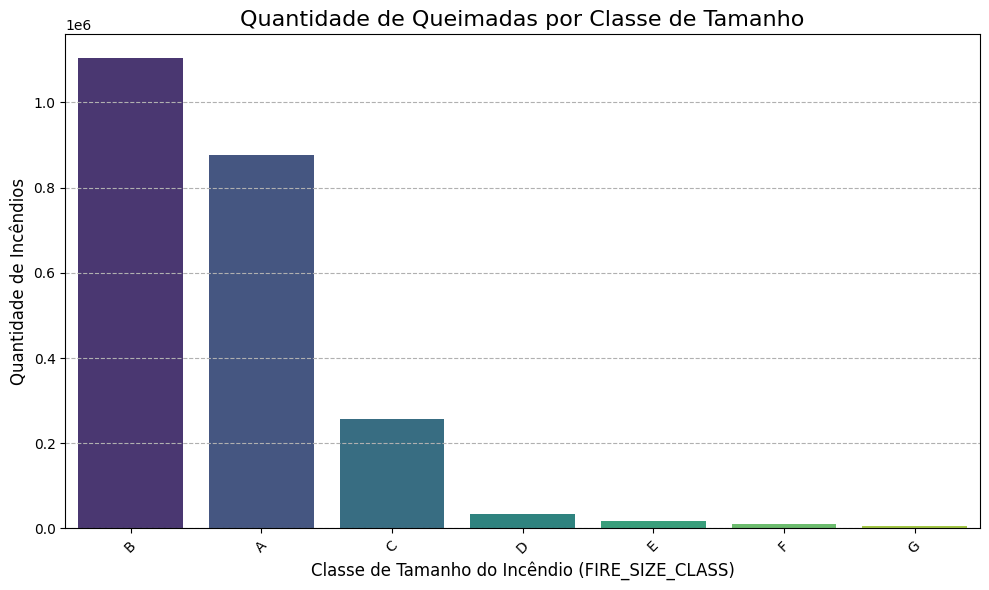

In [13]:
# Contar a frequência de cada classe de tamanho de incêndio
fire_class_counts = df['FIRE_SIZE_CLASS'].value_counts()

class_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

plt.figure(figsize=(10, 6)) 
sns.barplot(x=fire_class_counts.index, y=fire_class_counts.values, palette="viridis") 

plt.title('Quantidade de Queimadas por Classe de Tamanho', fontsize=16)
plt.xlabel('Classe de Tamanho do Incêndio (FIRE_SIZE_CLASS)', fontsize=12)
plt.ylabel('Quantidade de Incêndios', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.tight_layout() 
plt.show()


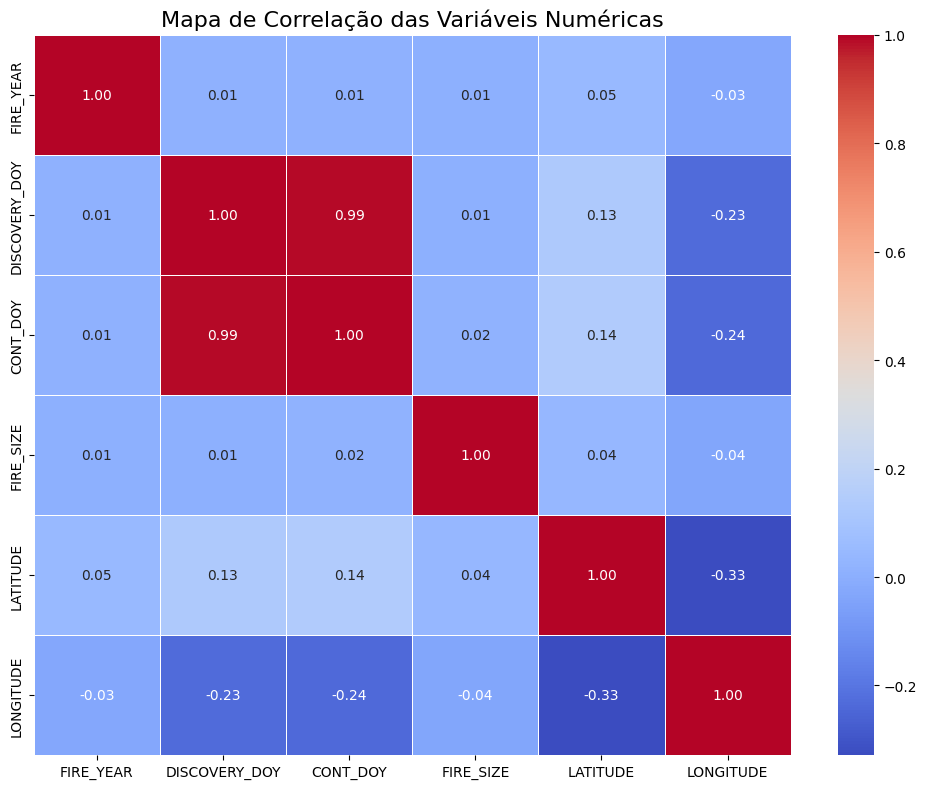

In [ ]:
# Mapa de correlação
numeric_cols = ['FIRE_YEAR', 'DISCOVERY_DOY', 'CONT_DOY', 'FIRE_SIZE', 'LATITUDE', 'LONGITUDE']
df_numeric = df[numeric_cols]

correlation_matrix = df_numeric.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Mapa de Correlação das Variáveis Numéricas', fontsize=16)
plt.tight_layout()
plt.show()